In [1]:
# OPTIONAL: Load the "autoreload" extension so that package code can change
%load_ext autoreload
# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

In [3]:
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyIEEM.models.utils import initialize_model

In [4]:
country = 'BE'
spatial = True
age_classes = pd.IntervalIndex.from_tuples([(0,5),(5,10),(10,15),(15,20),(20,25),(25,30),(30,35),(35,40),(40,45),(45,50),(50,55),(55,60),(60,65),(65,70),(70,75),(75,80),(80,120)], closed='left')

In [5]:
def compute_beta(R0, delta, gamma, s, N, demography):
    beta_i = R0/(s*(delta+gamma)*np.expand_dims(np.sum(N, axis=0),axis=1))
    return sum(np.squeeze(beta_i)*demography/sum(demography))

In [9]:
N = np.squeeze(model.parameters['N']['other'] + model.parameters['G']*model.parameters['N']['work'])
demography = pd.read_csv(f'../data/interim/epi/demographic/age_structure_{country}_2019.csv', index_col=[0, 1]).groupby(by='age').sum().squeeze()
demography = demography.groupby(pd.cut(demography.index.values, age_classes)).sum()
compute_beta(3.3, model.parameters['delta'], model.parameters['gamma'], model.parameters['s'], N, demography.values)

ValueError: operands could not be broadcast together with shapes (11,11) (17,17,11) 

In [7]:
model = initialize_model(country, age_classes, spatial=spatial, contact_type='absolute_contacts')

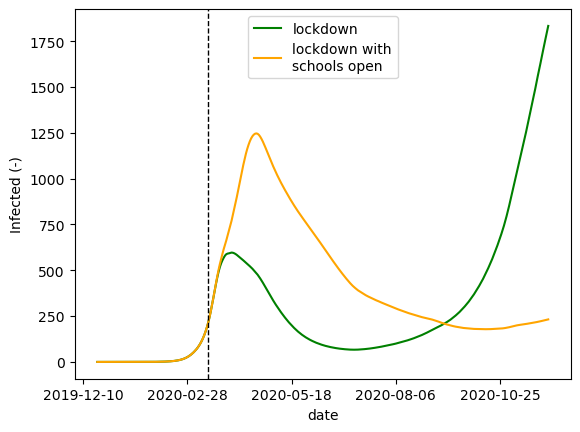

In [8]:
fig,ax = plt.subplots()

model.parameters['beta'] = 0.032
model.parameters['amplitude'] = 0.18

# economic lockdown, schools closed, preventive measures, social restrictions
model.parameters['economic_closures'].loc[slice(None)] = 1
out = model.sim(['2019-12-21', '2020-12-01'])
ax.plot(out.date, out.Hin.sum(dim=['age_class', 'spatial_unit']), color='green', label='lockdown')
#ax.plot(out.date, out.R.sum(dim=['age_class', 'spatial_unit']), color='green', label='lockdown')

# economic lockdown, schools open, preventive measures, social restrictions
model.parameters['economic_closures'].loc['P85'] = 0
out = model.sim(['2019-12-21', '2020-12-01'])
ax.plot(out.date, out.Hin.sum(dim=['age_class', 'spatial_unit']), 'orange', label='lockdown with\nschools open')

# do-nothing
#model.parameters['social_restrictions'] = 0
#model.parameters['preventive_measures'] = 0
#model.parameters['economic_closures'].loc[slice(None)] = 0
#out = model.sim(['2019-12-14', '2020-09-01'])
#ax.plot(out.date, out.Hin.sum(dim=['age_class', 'spatial_unit']), color='red', label='do nothing')

ax.legend()

ax.axvline(x=datetime(2020, 3, 15), color='black', linestyle='--', linewidth=1)
ax.set_xlabel('date')
ax.set_ylabel('Infected (-)')
ax.xaxis.set_major_locator(plt.MaxNLocator(5))
plt.show()
plt.close()